# FFT Analysis Testing

This notebook tests the FFT (Fast Fourier Transform) analysis functionality for converting time-domain signals to frequency-domain.

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Add parent directory to path
sys.path.insert(0, os.path.abspath('..'))
sys.path.insert(0, os.path.join(os.path.abspath('..'), 'Tests'))

from Normal_data_to_fft import (
    load_and_process_asc_file,
    extract_pump_channels,
    estimate_sampling_rate,
    apply_windowed_fft,
    select_frequency_range,
    process_all_channels_from_asc,
    visualize_asc_fft_results
)

print("Imports successful!")

Imports successful!


## 1. Load Test Data

In [2]:
# Path to test ASC file
test_file = '../Tests/Data/V24-2025__0021.ASC'

if os.path.exists(test_file):
    print(f"Loading file: {test_file}")
    df = load_and_process_asc_file(test_file)
    data = extract_pump_channels(df)
    print(f"\n✓ Loaded {len(data)} channels")
else:
    print(f"Test file not found: {test_file}")
    print("Creating synthetic test data instead...")
    
    # Create synthetic data
    t = np.linspace(0, 10, 10000)
    data = {
        'Messzeit[s]': t,
        'Pressure [bar]': 50 + 5*np.sin(2*np.pi*10*t) + 2*np.sin(2*np.pi*25*t) + np.random.normal(0, 0.5, len(t)),
        'Flow [L/min]': 100 + 10*np.sin(2*np.pi*15*t) + np.random.normal(0, 1, len(t)),
        'Speed [rpm]': 1500 + 50*np.sin(2*np.pi*5*t) + np.random.normal(0, 5, len(t))
    }
    print("✓ Created synthetic test data")

Loading file: ../Tests/Data/V24-2025__0021.ASC


2026-01-08 08:27:14,670 - INFO - Successfully loaded ASC file. Shape: (22800, 11)
2026-01-08 08:27:14,671 - INFO - Columns: ['Messzeit[s]', 'Pressure [bar]', 'Flow [L/min]', 'Leak [L/min]', 'Speed [rpm]', 'Torque [Nm]', 'LS [bar]', 'Housing [bar]', 'TempSaug [°C]', 'TempLeak [°C]', '']


STEP 2: EXTRACTING PUMP CHANNELS
Available columns in ASC file: ['Messzeit[s]', 'Pressure [bar]', 'Flow [L/min]', 'Leak [L/min]', 'Speed [rpm]', 'Torque [Nm]', 'LS [bar]', 'Housing [bar]', 'TempSaug [°C]', 'TempLeak [°C]', '']

Target channels: ['Messzeit[s]', 'Pressure [bar]', 'Flow [L/min]', 'Leak [L/min]', 'Speed [rpm]', 'Torque [Nm]', 'LS [bar]', 'Housing [bar]', 'TempSaug [°C]', 'TempLeak [°C]']

✓ Found: Messzeit[s]
✓ Found: Pressure [bar]
✓ Found: Flow [L/min]
✓ Found: Leak [L/min]
✓ Found: Speed [rpm]
✓ Found: Torque [Nm]
✓ Found: LS [bar]
✓ Found: Housing [bar]
✓ Found: TempSaug [°C]
✓ Found: TempLeak [°C]

Extracted 10 channels with 22800 samples each


✓ Loaded 10 channels


## 2. Test Single Channel FFT

Apply windowed FFT to a single channel and examine the results.

In [6]:
# Get time array
time_key = 'Messzeit[s]' if 'Messzeit[s]' in data else list(data.keys())[0]
t = data[time_key]
sampling_rate = estimate_sampling_rate(t)

# Select first signal channel
channel_names = [k for k in data.keys() if k != time_key]
test_channel = channel_names[0]

print(f"Testing FFT on channel: {test_channel}")
print(f"Sampling rate: {sampling_rate:.2f} Hz")

# Apply windowed FFT
freqs, fft_windows, fft_avg = apply_windowed_fft(
    signal=data[test_channel],
    window_size=1024,
    overlap=0.5,
    sampling_rate=sampling_rate,
    channel_name=test_channel
)

print(f"\n✓ FFT Results:")
print(f"  - Frequency bins: {len(freqs)}")
print(f"  - Frequency range: 0 to {freqs[-1]:.2f} Hz")
print(f"  - Number of windows: {fft_windows.shape[0]}")

STEP 3: ESTIMATING SAMPLING RATE
Time array length: 22800
Time range: [0.1000, 15.2993] s
Duration: 15.1993 s
Average sampling interval: 0.000667 s
Estimated sampling rate: 1500.00 Hz
Sampling interval std: 0.000000 s

Testing FFT on channel: Pressure [bar]
Sampling rate: 1500.00 Hz
STEP 4: WINDOWED FFT - Pressure [bar]
Signal length: 22800 samples
Window size: 1024 samples (0.683 s)
Overlap: 50%
Step size: 512 samples
Number of windows: 43

FFT computed for 43 windows
Frequency bins: 513
Frequency resolution: 1.4648 Hz
Max frequency: 750.00 Hz

Top 5 dominant frequencies (averaged):
  1. Frequency:    1.46 Hz, Magnitude: 74.377435
  2. Frequency:    0.00 Hz, Magnitude: 73.606309
  3. Frequency:    2.93 Hz, Magnitude: 2.378362
  4. Frequency:    4.39 Hz, Magnitude: 1.334812
  5. Frequency:    5.86 Hz, Magnitude: 0.920286


✓ FFT Results:
  - Frequency bins: 513
  - Frequency range: 0 to 750.00 Hz
  - Number of windows: 43


## 3. Visualize Single Channel FFT Results


Top 5 Frequencies:
  1.    1.46 Hz (magnitude: 74.377435)
  2.    0.00 Hz (magnitude: 73.606309)
  3.    2.93 Hz (magnitude: 2.378362)
  4.    4.39 Hz (magnitude: 1.334812)
  5.    5.86 Hz (magnitude: 0.920286)


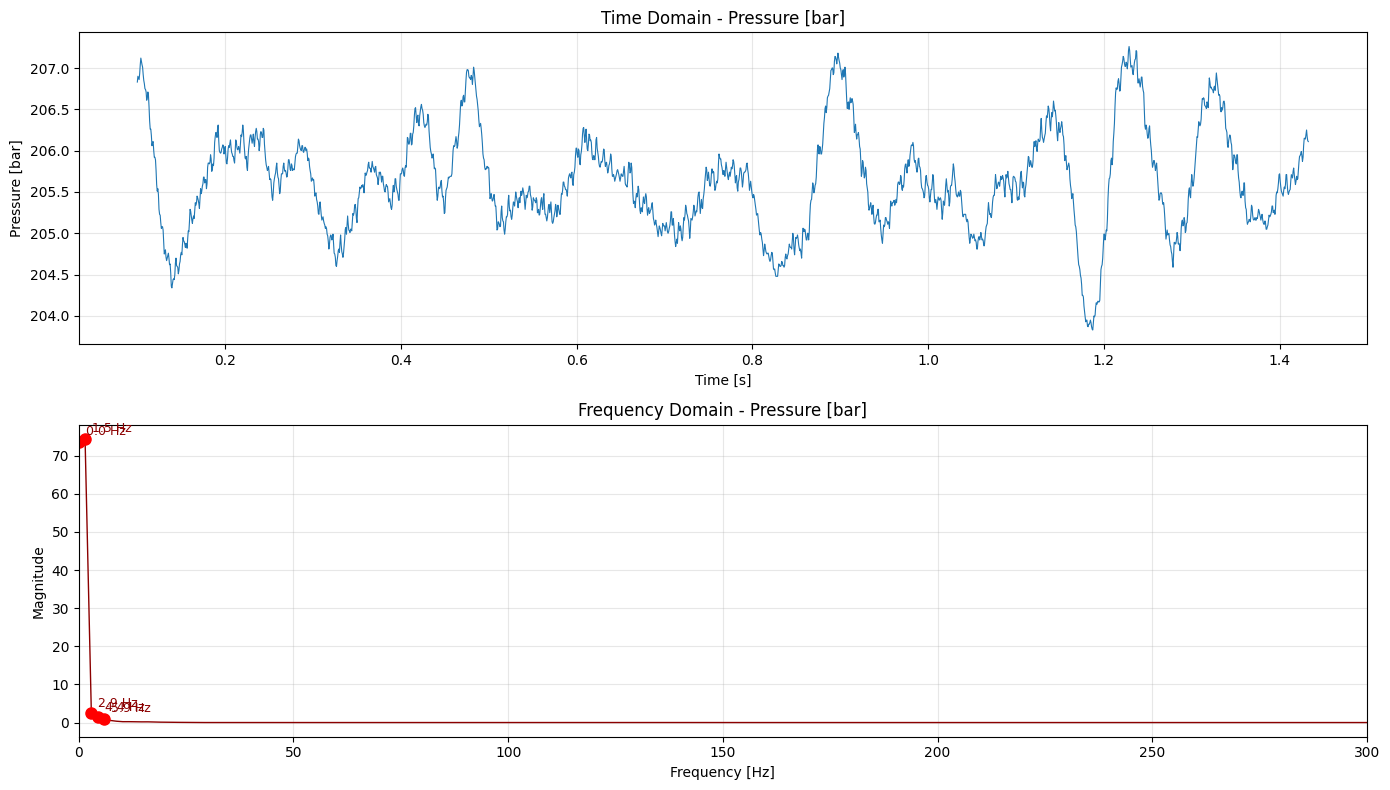

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Time domain
axes[0].plot(t[:2000], data[test_channel][:2000], linewidth=0.8)
axes[0].set_xlabel('Time [s]')
axes[0].set_ylabel(test_channel)
axes[0].set_title(f'Time Domain - {test_channel}')
axes[0].grid(True, alpha=0.3)

# Frequency domain
axes[1].plot(freqs, fft_avg, linewidth=1.0, color='darkred')
axes[1].set_xlabel('Frequency [Hz]')
axes[1].set_ylabel('Magnitude')
axes[1].set_title(f'Frequency Domain - {test_channel}')
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim([0, min(300, freqs[-1])])

# Mark top peaks
top_indices = np.argsort(fft_avg)[-5:][::-1]
print(f"\nTop 5 Frequencies:")
for i, idx in enumerate(top_indices, 1):
    freq = freqs[idx]
    mag = fft_avg[idx]
    print(f"  {i}. {freq:7.2f} Hz (magnitude: {mag:.6f})")
    axes[1].plot(freq, mag, 'ro', markersize=8)
    axes[1].annotate(f'{freq:.1f} Hz', xy=(freq, mag), 
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=9, color='darkred')

plt.tight_layout()
plt.show()

## 4. Test Frequency Range Selection

STEP 5: FREQUENCY RANGE SELECTION
Original frequency bins: 513
Selected frequency bins: 69
Frequency range: 0 - 100 Hz
Selected frequency range: [0, 99.61] Hz
Reduction factor: 7.43x

STEP 5: FREQUENCY RANGE SELECTION
Original frequency bins: 513
Selected frequency bins: 171
Frequency range: 0 - 250 Hz
Selected frequency range: [0, 249.02] Hz
Reduction factor: 3.00x

STEP 5: FREQUENCY RANGE SELECTION
Original frequency bins: 513
Selected frequency bins: 342
Frequency range: 0 - 500 Hz
Selected frequency range: [0, 499.51] Hz
Reduction factor: 1.50x



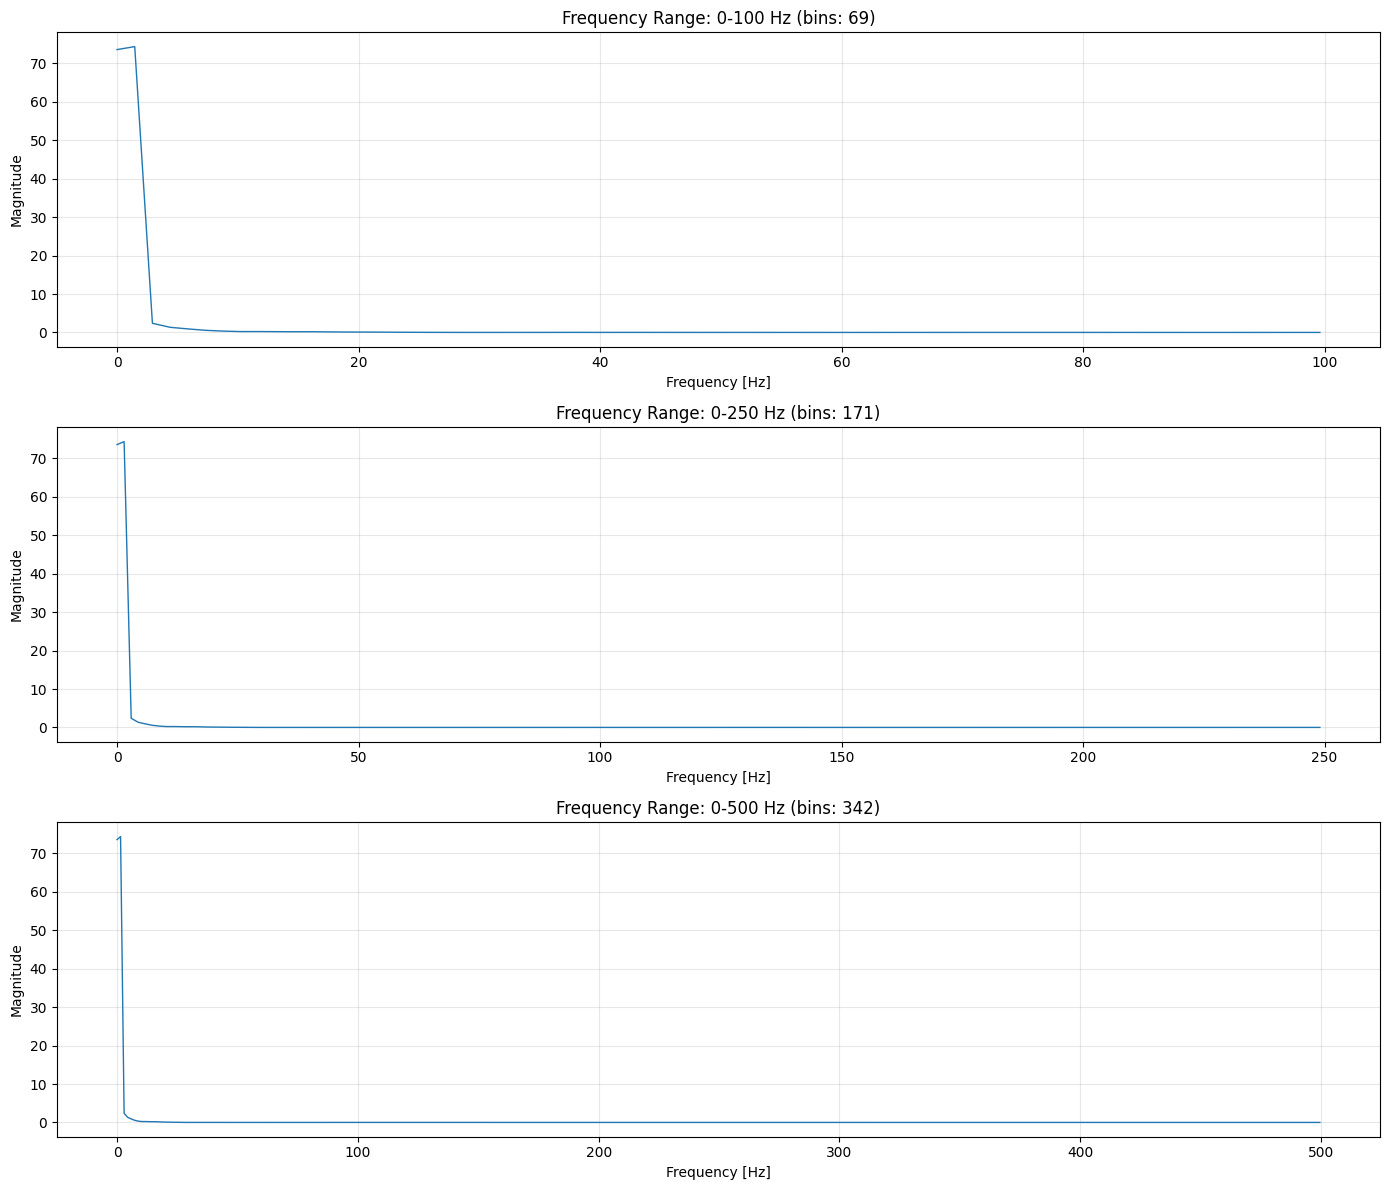

In [8]:
# Test different frequency ranges
max_frequencies = [100, 250, 500]

fig, axes = plt.subplots(len(max_frequencies), 1, figsize=(14, 4 * len(max_frequencies)))

for i, max_freq in enumerate(max_frequencies):
    selected_freqs, selected_mag = select_frequency_range(
        freqs, fft_avg, max_freq=max_freq
    )
    
    axes[i].plot(selected_freqs, selected_mag, linewidth=1.0)
    axes[i].set_xlabel('Frequency [Hz]')
    axes[i].set_ylabel('Magnitude')
    axes[i].set_title(f'Frequency Range: 0-{max_freq} Hz (bins: {len(selected_freqs)})')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Test Multi-Channel FFT Processing

In [9]:
# Process all channels
freqs, fft_features, feature_matrix = process_all_channels_from_asc(
    data,
    window_size=1024,
    overlap=0.5,
    max_freq=500.0
)

print(f"\n✓ Multi-channel FFT complete!")
print(f"  - Feature matrix shape: {feature_matrix.shape}")
print(f"  - Frequency bins: {feature_matrix.shape[0]}")
print(f"  - Channels processed: {feature_matrix.shape[1]}")
print(f"  - Total features: {feature_matrix.size}")

STEP 6: MULTI-CHANNEL FFT PROCESSING
STEP 3: ESTIMATING SAMPLING RATE
Time array length: 22800
Time range: [0.1000, 15.2993] s
Duration: 15.1993 s
Average sampling interval: 0.000667 s
Estimated sampling rate: 1500.00 Hz
Sampling interval std: 0.000000 s

Detected average shaft speed: 1506.0 RPM (25.10 Hz)
Processing 9 channels:
  1. Pressure [bar]
  2. Flow [L/min]
  3. Leak [L/min]
  4. Speed [rpm]
  5. Torque [Nm]
  6. LS [bar]
  7. Housing [bar]
  8. TempSaug [°C]
  9. TempLeak [°C]

STEP 4: WINDOWED FFT - Pressure [bar]
Signal length: 22800 samples
Window size: 1024 samples (0.683 s)
Overlap: 50%
Step size: 512 samples
Number of windows: 43

FFT computed for 43 windows
Frequency bins: 513
Frequency resolution: 1.4648 Hz
Max frequency: 750.00 Hz

Top 5 dominant frequencies (averaged):
  1. Frequency:    1.46 Hz, Magnitude: 74.377435
  2. Frequency:    0.00 Hz, Magnitude: 73.606309
  3. Frequency:    2.93 Hz, Magnitude: 2.378362
  4. Frequency:    4.39 Hz, Magnitude: 1.334812
  5. F

## 6. Visualize Feature Matrix

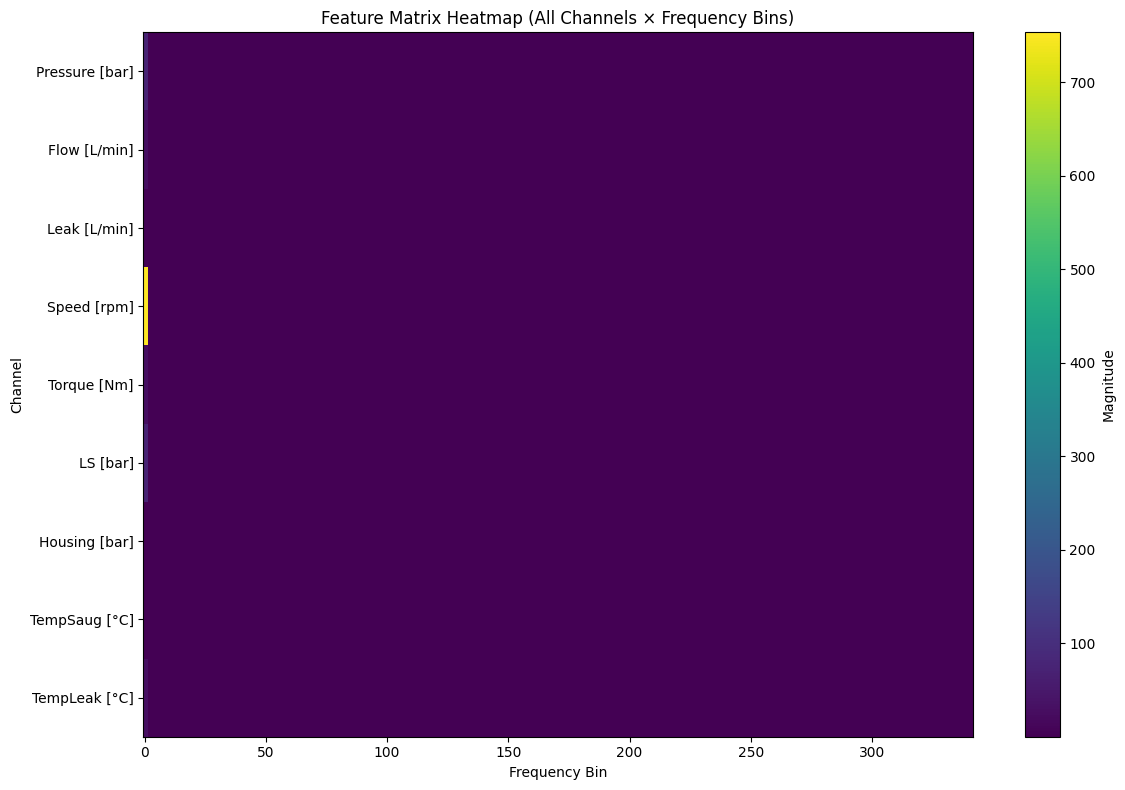

In [10]:
# Heatmap of feature matrix
fig, ax = plt.subplots(figsize=(12, 8))

im = ax.imshow(feature_matrix.T, aspect='auto', cmap='viridis', interpolation='nearest')
ax.set_xlabel('Frequency Bin')
ax.set_ylabel('Channel')
ax.set_title('Feature Matrix Heatmap (All Channels × Frequency Bins)')
ax.set_yticks(range(len(channel_names)))
ax.set_yticklabels(channel_names)

plt.colorbar(im, ax=ax, label='Magnitude')
plt.tight_layout()
plt.show()

## 7. Compare FFT Windows (Temporal Evolution)

STEP 5: FREQUENCY RANGE SELECTION


IndexError: boolean index did not match indexed array along axis 0; size of axis is 513 but size of corresponding boolean axis is 342

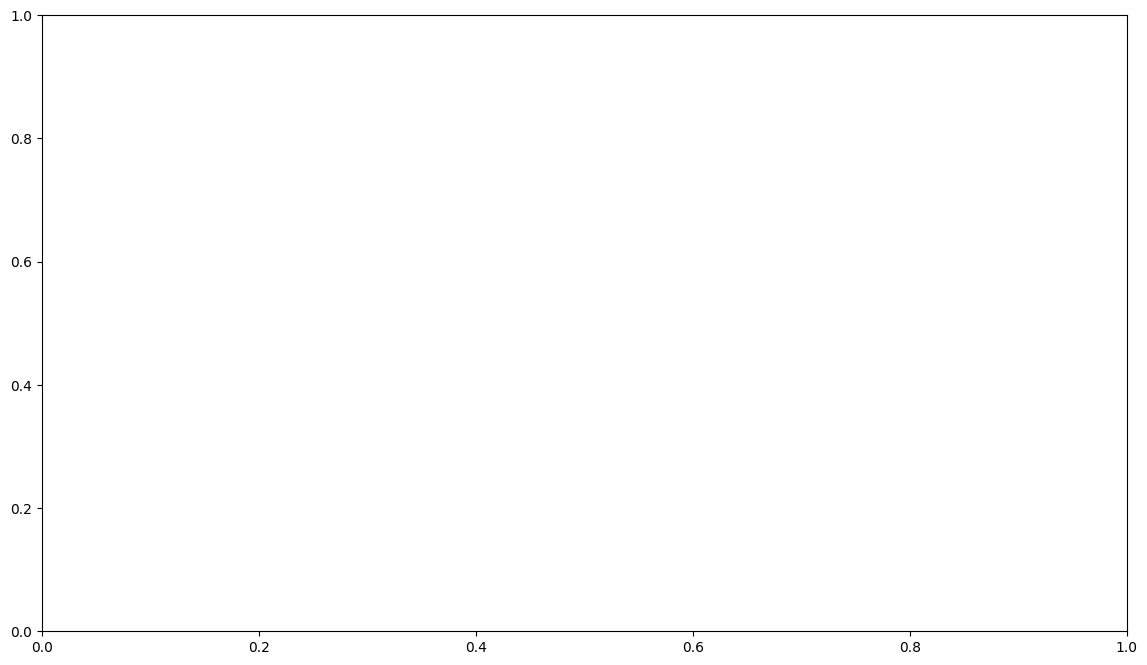

In [11]:
# Show how FFT changes over time (different windows)
fig, ax = plt.subplots(figsize=(14, 8))

# Plot first few windows
n_windows_to_plot = min(5, fft_windows.shape[0])

for i in range(n_windows_to_plot):
    selected_freqs, selected_mag = select_frequency_range(
        freqs, fft_windows[i, :], max_freq=200
    )
    ax.plot(selected_freqs, selected_mag, label=f'Window {i+1}', alpha=0.7, linewidth=1.5)

ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Magnitude')
ax.set_title('FFT Across Different Time Windows')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Export Feature Matrix for ML Models

In [12]:
# Flatten feature matrix for autoencoder input
flattened_features = feature_matrix.flatten()

print("Feature Matrix Export Options:")
print("=" * 60)
print(f"\nOption 1 - Flattened vector:")
print(f"  Shape: {flattened_features.shape}")
print(f"  Use case: Single sample input to autoencoder")

print(f"\nOption 2 - 2D matrix:")
print(f"  Shape: {feature_matrix.shape}")
print(f"  Use case: Batch input where each frequency bin is a sample")

print(f"\nOption 3 - Per-channel features:")
for i, channel in enumerate(channel_names):
    print(f"  {channel}: {fft_features[channel].shape}")

# Save to file (optional)
# np.save('feature_matrix.npy', feature_matrix)
# print("\n✓ Feature matrix saved to feature_matrix.npy")

Feature Matrix Export Options:

Option 1 - Flattened vector:
  Shape: (3078,)
  Use case: Single sample input to autoencoder

Option 2 - 2D matrix:
  Shape: (342, 9)
  Use case: Batch input where each frequency bin is a sample

Option 3 - Per-channel features:
  Pressure [bar]: (342,)
  Flow [L/min]: (342,)
  Leak [L/min]: (342,)
  Speed [rpm]: (342,)
  Torque [Nm]: (342,)
  LS [bar]: (342,)
  Housing [bar]: (342,)
  TempSaug [°C]: (342,)
  TempLeak [°C]: (342,)


## 9. Summary

In [13]:
print("\n" + "=" * 70)
print("FFT ANALYSIS TEST SUMMARY")
print("=" * 70)
print(f"✓ Sampling rate: {sampling_rate:.2f} Hz")
print(f"✓ Window size: 1024 samples")
print(f"✓ Overlap: 50%")
print(f"✓ Channels processed: {len(channel_names)}")
print(f"✓ Frequency range: 0 - {freqs[-1]:.2f} Hz")
print(f"✓ Feature matrix shape: {feature_matrix.shape}")
print(f"✓ Total features: {feature_matrix.size}")
print("=" * 70)


FFT ANALYSIS TEST SUMMARY
✓ Sampling rate: 1500.00 Hz
✓ Window size: 1024 samples
✓ Overlap: 50%
✓ Channels processed: 9
✓ Frequency range: 0 - 499.51 Hz
✓ Feature matrix shape: (342, 9)
✓ Total features: 3078
